# Overview

#### Objective: Develop target list of companies to explore further. 
###### Traingulating:
- Growth
- Age
- Business health

### Config

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.options.display.float_format = '{:,}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# SBA Lending Data

### Loading Data

In [ ]:
# lending_data_504 = pd.read_csv("data/FOIA - 504 (FY1991-Present).csv", encoding = "ISO-8859-1")

In [ ]:
lending_data_7a_91t99 = pd.read_csv("data/FOIA - 7(a)(FY1991-FY1999).csv")

In [ ]:
lending_data_7a_00t09 = pd.read_csv("data/FOIA - 7(a)(FY2000-FY2009).csv", encoding="ISO-8859-1")

In [ ]:
lending_data_7a_10tPR = pd.read_csv("data/FOIA - 7(a)(FY2010-Present).csv")

In [68]:
dict_7a = pd.read_csv("data/7a_FOIA_Data_Dictionary.csv")

In [ ]:
naics_codes = pd.read_csv("data/naics-codes.csv", header=None)

### Cleanup

In [ ]:
lending_data_7a_91t99.drop(['AsOfDate', 'Program'], axis=1, inplace=True)
lending_data_7a_00t09.drop(['AsOfDate', 'Program'], axis=1, inplace=True)
lending_data_7a_10tPR.drop(['AsOfDate', 'Program'], axis=1, inplace=True)

In [ ]:
dict_7a.columns = ['Field_Name', "Definition"]

In [ ]:
naics_codes.columns = ['code', 'desc']

In [ ]:
lending_data_7a_91t99 = pd.merge(lending_data_7a_91t99, naics_codes, left_on="NaicsCode", right_on='code')
lending_data_7a_00t09 = pd.merge(lending_data_7a_00t09, naics_codes, left_on="NaicsCode", right_on='code')
lending_data_7a_10tPR = pd.merge(lending_data_7a_10tPR, naics_codes, left_on="NaicsCode", right_on='code')

In [ ]:
lending_data_7a_91t99['group'] = '1991-1999'
lending_data_7a_00t09['group'] = '2000-2009'
lending_data_7a_10tPR['group'] = '2010-2020'

In [ ]:
lend_df = pd.concat([lending_data_7a_91t99,lending_data_7a_00t09,lending_data_7a_10tPR])

In [ ]:
lend_df = lend_df.reset_index(drop=True)

In [ ]:
lend_df.to_csv("data/lending_data_7a_1991-2020.csv")

## Load clean

In [3]:
pd.set_option('display.max_rows', 40)

In [4]:
lend_df = pd.read_csv("data/lending_data_7a_1991-2020.csv").drop("Unnamed: 0", axis=1)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dict_7a = pd.read_csv("data/7a_FOIA_Data_Dictionary.csv")

In [6]:
dict_7a

,Field Name,Definition
0,Program,Indicator of whether loan was approved under SBA's 7(a) or 504 loan program
1,BorrName,Borrower name
2,BorrStreet,Borrower street address
3,BorrCity,Borrower city
4,BorrState,Borrower state
5,BorrZip,Borrower zip code
6,BankName,Name of the bank that the loan is currently assigned to
7,BankStreet,Bank street address
8,BankCity,Bank city
9,BankState,Bank state


# 1. Filtering companies using location, lending amts, headcount, etc.

In [9]:
lend_df.GrossApproval

0           140000
1            95000
2           115000
3            50000
4            80000
            ...   
1193009    2497000
1193010     100000
1193011      15000
1193012      15000
1193013    1268300
Name: GrossApproval, Length: 1193014, dtype: int64

# 2. How do interest rates, volume, etc. differ by groupings

In [6]:
import scipy.stats as stats

## Interest rates

In [14]:
interest_df = lend_df[~lend_df["InitialInterestRate"].isnull()][['BorrName', 'InitialInterestRate', 'ApprovalDate', 'FirstDisbursementDate', 'code', 'desc']]

In [36]:
interest_group = interest_df[['desc', 'InitialInterestRate']].groupby('desc', as_index=False).agg(
                      {'InitialInterestRate':['mean','std', 'count']})

In [63]:
interest_group[interest_group[('InitialInterestRate','count')] > 50].sort_values([('InitialInterestRate','mean')])

desc  \
                                                                      
800                                              Private Households   
208                  Conveyor and Conveying Equipment Manufacturing   
722                               Packaging Machinery Manufacturing   
918   Special Die and Tool, Die Set, Jig, and Fixture Manufacturing   
299                  Fabricated Pipe and Pipe Fitting Manufacturing   
...                                                             ...   
25                             All Other General Merchandise Stores   
1026        Wireless Telecommunications Carriers (except Satellite)   
60                  All Other Support Activities for Transportation   
557                                      Musical Groups and Artists   
282                       Electronic Shopping and Mail-Order Houses   

     InitialInterestRate                           
                    mean                std count  
800    5.536031746031746 0.8624282735301103   126  
208    5.608472222222222 1.3252357321233084    72  
722               5.6737 1.5011140642530485    60  
918    5.693318007662837  1.234349459004097   261  
299    5.696818181818181  1.294019568382427    66  
...                  ...                ...   ...  
25     7.585496183206105 1.6929292836975514   131  
1026               7.602 1.4700512321004324    65  
60     7.609307531380744 1.8679989583991945   478  
557    7.878714285714286 1.6635477572951267   140  
282    8.749448000000102 1.8594409542405625  3375  

[651 rows x 4 columns]

In [64]:
interest_group[interest_group[('InitialInterestRate','count')] > 50].sort_values([('InitialInterestRate','mean')]).to_csv('interest_mean_std_by_group.csv')

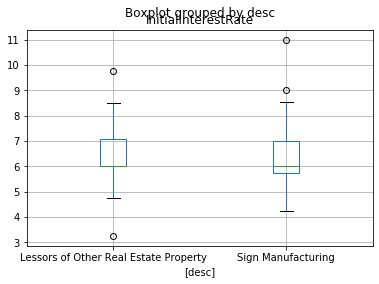

In [30]:
interest_df[:100][['desc', 'InitialInterestRate']].boxplot(by='desc')

## Volume

In [5]:
amount_df = lend_df[~lend_df["GrossApproval"].isnull()][['BorrName', 'GrossApproval', 'ApprovalDate', 'FirstDisbursementDate', 'code', 'desc']]

In [15]:
amount_group = amount_df[['desc', 'GrossApproval']].groupby('desc', as_index=False).agg(
                      {'GrossApproval':['mean','std', 'count']})

In [18]:
amount_group[amount_group[('GrossApproval','count')] > 50].sort_values([('GrossApproval','mean')])

desc  \
                                                                          
117                                               Blood and Organ Banks   
662  Other Direct Insurance (except Life, Health, and Medical) Carriers   
348                                   Footwear and Leather Goods Repair   
82                                              Apprenticeship Training   
564                                          Musical Groups and Artists   
..                                                                  ...   
834                                Refrigerated Warehousing and Storage   
89                           Assisted Living Facilities for the Elderly   
387                           Grain and Field Bean Merchant Wholesalers   
480                    Lessors of Miniwarehouses and Self-Storage Units   
418                            Hotels (except Casino Hotels) and Motels   

           GrossApproval                              
                    mean                  std  count  
117             34,400.0   93,216.40883666617     90  
662   55,988.04154302671  284,596.60074721085    337  
348    63,354.2600896861  168,807.81403304983    223  
82   63,380.670731707316  187,124.87768003158     82  
564   73,902.28571428571   190,123.3163245196    350  
..                   ...                  ...    ...  
834   846,945.3623188406 1,112,450.5130915286    138  
89    856,064.4105080832  1,022,772.065806388   1732  
387   922,709.8971428572 1,153,501.8281706069    175  
480 1,258,816.7248764415 1,324,345.7406842173   1214  
418  1,434,118.820993559  1,233,655.838211468  15681  

[798 rows x 4 columns]

In [19]:
amount_group[amount_group[('GrossApproval','count')] > 50].sort_values([('GrossApproval','mean')]).to_csv('amount_mean_std_by_group.csv')

#### Volume - ANOVA Testing

In [8]:
from statsmodels.formula.api import ols

In [ ]:
results = ols('GrossApproval ~ C(desc)', data=amount_df).fit()

In [ ]:
results.summary()


# 3. How to determine if company is still alive